# Codificação superdensa

`Protocolo SDC (Superdense Coding)`


## 1. Diferença entre codificação superdensa e teletransporte quântico<a id='difference'></a>

Ambos estão muito relacionados porém apresentam diferenças. 

O `teletransporte quântico` é o processo no qual o estado do qubit $|\psi\rangle$ pode ser trasmitido de um lugar ao outro usando dois bits clássicos de comunicação e estados de Bell. Pode-se dizer que este protocolo destrói um estado quântico de um qubit no local e recria-o em um qubit distante do localização através do emaranhamento. 

A `codificação superdensa` é o processo que permite enviar dois bits clássicos para outro conjunto de bits através de um único qubit de comunicação.

| Teletransporte <br>quântico | Codificação <br>superdensa  |
|:-----------------------:|:-----------------------------:|
| Transmite **um** qubit<br> usando **dois**<br>classical bits | Transmite **dois**<br>bits clássicos<br>usando **um** qubit |


O teleporte quântico pode ser observado como um protocolo inverso da codificação superdensa, ou seja, seria como se Alice e Bob "trocassem seus equipamentos".



## 2. O processo <a id='process'></a>

![image1](https://qiskit.org/textbook/ch-algorithms/images/superdense.jpg)

### 2.1 Passo 1 - Charlie <a id='step1'></a>
Primeiramente um indivíduo chamado Charlie prepara dois qubits em um estado emaranhado. Os dois qubits iniciais estão no estado $|0\rangle$. Ele aplica a porta Hadamar no primeiro qubit para criar a superposição e posteriormente aplica a porta CNOT tal que o primeiro qubit seja o de controle e o segundo, o qubit alvo. Através disso surge o estado de Bell.

#### Destrinchando

Aplicação do Hadamard no primeiro qubit:

$$|0+\rangle  =  \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle)$$


Aplicando a porta CNOT, ou seja, emaranhando ambos qubits:

$$\text{CNOT} \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$



### 2.2 Passo 2 - Alice <a id='step2'></a>

Charlie envia o primeiro qubit para Alice e o segundo para Bob. Alice então envia os dois bits clássicos para Bob através de um qubit. Portanto antes de enviar, Alice aplica um conjunto de portas quânticas no seu qubit dependentes dos dois bits clássicos. Logo, ela deseja enviar:

-*Regras de codificação (SDC) para Alice*-

| Mensagem desejada | Porta aplicada | Estado resultante ($\cdot\sqrt{2}$)|
|:----------------:|:------------:|:--------------------------------:|
|00                |$I$           | $|00\rangle + |11\rangle$        |
|10                |$X$           | $|01\rangle + |10\rangle$        |
|01                |$Z$           | $|00\rangle - |11\rangle$        |
|11                |$ZX$          | $|10\rangle - |01\rangle$        |

Dependendo da informação que Alice quer enviar, ela aplica uma porta específica e posteriormente envia seu qubit para Bob.


### 2.3 Passo 3  - Bob<a id='step3'></a>

Bob recebe o qubit de Alice e através dele decodifica a mensagem de Alice. Vale ressaltar que ele não precisa conhecer o estado em ordem para decodificá-lo.

Bob aplica a porta CNOT usando o qubit recebido de Alice como o bit de controle e o recebido de Charlie como bit alvo. Depois aplica a porta Hadamard e faz a medição em ambos qubits para finalmente decodificar a mensagem de Alice.

| Informação recebida por Bob             | Aplicação da porta CNOT          | Aplicação da porta H  |
|:-------------------------:|:-------------------------:|:--------------:|
| $|00\rangle + |11\rangle$ | $|00\rangle + |01\rangle$ | $|00\rangle$   |
| $|01\rangle + |10\rangle$ | $|10\rangle + |11\rangle$ | $|10\rangle$   |
| $|00\rangle - |11\rangle$ | $|00\rangle - |01\rangle$ | $|01\rangle$   |
| $|10\rangle - |01\rangle$ | $|11\rangle - |10\rangle$ | $|11\rangle$   |


When Bob performs the measurements, he is certain to get the message Alice sent him. Note that the last outcome has a negative sign $-|11\rangle$, writing it as $|11\rangle$ is also correct as this is global phase and is not measureable.


## 3. Simulação de protocolo SDC<a id='simulating'></a>

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
# muda as configs para melhorar a qualidade das imagens para svg
%config InlineBackend.figure_format = 'svg'

# função para criar um estado de bell 
def create_bell_pair(qc, a, b):
    qc.h(a) # aplica h
    qc.cx(a,b) # aplica CNOT, onde a é o bit de controle e b o alvo

Agora é feita a codificação da mensagem. Há quatro possíveis mensagens a serem enviadas: `00`, `10`, `01` ou `11`. Cada possível mensagem aplica-se uma porta específica:

In [2]:
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # aplica identidade
    elif msg == "10":
        qc.x(qubit) # aplica porta X
    elif msg == "01":
        qc.z(qubit) # aplica porta Z
    elif msg == "11":
        qc.z(qubit) # aplica porta Z
        qc.x(qubit) # aplica porta X
    else:
        print("Invalid Message")

Decodificando a mensagem, ou seja, aplica-se uma CNOT seguida de uma Hadamard:

In [3]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

Finalmente colocando tudo em um protocolo:

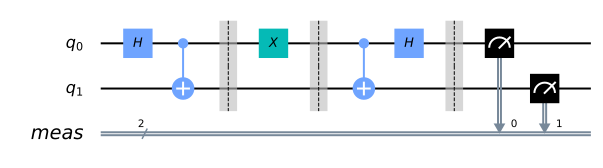

In [4]:
# circuito quantico com 2 qubits
qc = QuantumCircuit(2)

# Charlie cria o emaranhamento entre Alice e Bob
create_bell_pair(qc, 0, 1)
qc.barrier()
# qubit 0 vai para Alice e qubit 1 para o Bob

# Alice codifica seu qubit. Neste caso ela deseja enviar a mensagem '10'.
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice envia seu qubit para Bob.
# Após receber o qubit 0, Bob o protocolo de decodificação:
decode_message(qc, 0, 1)

# Bob seus qubits
qc.measure_all()

qc.draw(output = "mpl")

### 3.1 Visualizando as medidas <a id='visualising'></a>

{'10': 1024}


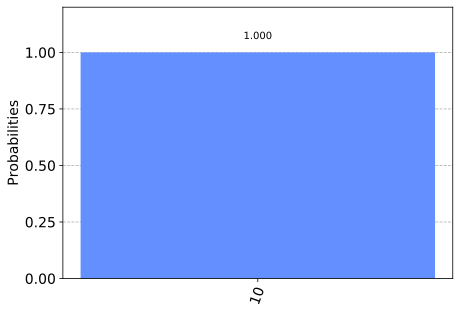

In [5]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

Na simulação há uma medição perfeita das mensagens onde não exite erro.

## 4. SCD no computador quântico real<a id='real_qc'></a>

In [6]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 512

# Carrega informações da conta
IBMQ.load_account()
# Escolhe o backend menos ocupado
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Rodando o circuito
job = execute(qc, backend=backend, shots=shots)

RequestsApiError: "HTTPSConnectionPool(host='auth.quantum-computing.ibm.com', port=443): Max retries exceeded with url: /api/version (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fc6b5455450>, 'Connection to auth.quantum-computing.ibm.com timed out. (connect timeout=5.0)'))"

In [ ]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

In [ ]:
# Plotando resultados
result = job.result()
plot_histogram(result.get_counts(qc))

No computador quântico real existem erros devido a incoerências do mundo real. Portanto apresenta uma precisão calculada de:

In [ ]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print("Accuracy = %.2f%%" % accuracy)